In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools
import matplotlib
import numba
#%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

np.random.seed(0)



#Function to define the turning point of a cumulative curve by using the minimum derivative method
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
def turn_point(sgRNA_name, df):
    sgRNA_count  = df.T.filter(items=[sgRNA_name]).sum(axis=1).sort_values(ascending=False)
    sgRNA_cumsum = sgRNA_count.cumsum()

    #get the total cell number of this sgRNA
    cell_num = np.argwhere(sgRNA_count > 0).size

    #calculate the turning point by using the max derivative
    turning_point = sgRNA_cumsum.loc[((sgRNA_cumsum.diff()) / sgRNA_count.sum() > (1/cell_num))].shape
    
    return(sgRNA_count.iloc[turning_point])

#load sgRNA-barcode data
def load_data(input_file):
    input_fh  = open(input_file, 'r')
    #define parameters
    cell_bc_list   = []
    num_sgRNA_list = np.array([])
    sgRNAs         = []
    umis           = []
    
    #initiate a 2D dictionary
    data_dict = nested_dict(2, list)
    for line in input_fh:
        cell_bc    = line.strip().split('\t')[0] + '-1'
        num_sgRNA  = line.strip().split('\t')[2]
        sgRNA_list = line.strip().split('\t')[3].split(';')
        umi_list   = line.strip().split('\t')[5].split(';')
        full_cell_bc = cell_bc
        for i in zip(sgRNA_list, umi_list):
            data_dict[full_cell_bc][i[0]] = i[1]
    
    #read the 2D dictionary into the pandas DataFrame
    df = pd.DataFrame(data_dict).fillna(0).astype(int)    
    return df

#filter the sgRNA UMI count based on the cutoff values
def filter_umi (df):
    #calculate the cutoff value for each sgRNA in the dataset
    sgRNA_cutoff = [[turn_point(i, df)] for i in list(df.index)]
    
    for i in range(0, len(sgRNA_cutoff)):
        df.iloc[i, :].loc[df.iloc[i, :] <= sgRNA_cutoff[i][0]] = 0
    return df

In [2]:
WORK_DIR = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/YW49-YW54_10x_mapping/nova_seq_data/sgRNA_lib_regex/'

YW61_df = load_data(WORK_DIR + 'YW61.summarized_sgRNA/YW61.sgRNA_count.txt')
#YW62_df = load_data(WORK_DIR + 'YW62.summarized_sgRNA/YW62.sgRNA_count.txt')
#YW63_df = load_data(WORK_DIR + 'YW63.summarized_sgRNA/YW63.sgRNA_count.txt')
#YW64_df = load_data(WORK_DIR + 'YW64.summarized_sgRNA/YW64.sgRNA_count.txt')
#YW65_df = load_data(WORK_DIR + 'YW65.summarized_sgRNA/YW65.sgRNA_count.txt')
#YW66_df = load_data(WORK_DIR + 'YW66.summarized_sgRNA/YW66.sgRNA_count.txt')

YW61_df_adj = filter_umi(YW61_df)
#YW62_df_adj = filter_umi(YW62_df)
#YW63_df_adj = filter_umi(YW63_df)
#YW64_df_adj = filter_umi(YW64_df)
#YW65_df_adj = filter_umi(YW65_df)
#YW66_df_adj = filter_umi(YW66_df)

#### rename the column for each df

def rename_BC(df, number):
    BC_list = []
    for i in df.columns:
        new_BC = i + number
        BC_list.append(new_BC)

    df.columns = BC_list

#rename_BC(YW62_df_adj, '-2')
rename_BC(YW63_df_adj, '-3')
rename_BC(YW64_df_adj, '-4')
rename_BC(YW65_df_adj, '-5')
rename_BC(YW66_df_adj, '-6')

#### combine all the df

In [4]:
YW61 = pd.read_pickle(WORK_DIR + 'YW61.sgRNA_adj_df_UMI2.pkl')
YW62 = pd.read_pickle(WORK_DIR + 'YW62.sgRNA_adj_df_UMI2.pkl')
YW63 = pd.read_pickle(WORK_DIR + 'YW63.sgRNA_adj_df_UMI2.pkl')
YW64 = pd.read_pickle(WORK_DIR + 'YW64.sgRNA_adj_df_UMI2.pkl')
YW65 = pd.read_pickle(WORK_DIR + 'YW65.sgRNA_adj_df_UMI2.pkl')
YW66 = pd.read_pickle(WORK_DIR + 'YW66.sgRNA_adj_df_UMI2.pkl')

In [6]:
sgRNA_df_adj_nova_regex = pd.concat([YW61, YW62, YW63, YW64, YW65, YW66], axis=1)

/home2/s426305/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [7]:
sgRNA_df_adj_nova_regex.shape

(20133, 77218)

sgRNA_df_adj_nova_regex.to_pickle('/project/GCRB/Hon_lab/s426305/Analysis/Mosaic_seq_MB231-dCas9-KRAB+YWsg1/Files/sgrna_df_adj_nova_regex.pkl')

### Calculate average number of guides per cell

In [8]:
def get_sgrna_per_cell(df, return_mean=True, return_median=True):
    CorrSgrnaPerCell = np.sum(df > 0, 0)
    sgrna_mean = np.mean(CorrSgrnaPerCell)
    sgrna_median = np.median(CorrSgrnaPerCell)
    print("Average sgRNA Number per Cell is: " + str(sgrna_mean))
    
    if return_mean & return_median:
        return CorrSgrnaPerCell, sgrna_mean, sgrna_median
    elif return_mean:
        return CorrSgrnaPerCell, sgrna_mean
    elif return_median:
        return CorrSgrnaPerCell, sgrna_median
    else:
        return CorrSgrnaPerCell

In [4]:
sgRNA_df_adj_nova_regex = pd.read_pickle('/home2/s426305/jupyter_notebooks/MOSAIC-seq_analysis/YW49-YW61_Nova_Seq/sgrna_df_adj_nova_regex.pkl')
#sgrna_df_adj_next_kallisto = pd.read_pickle('/home2/s426305/jupyter_notebooks/10x/YW49-YW66/Regex_kallisto pipelines comparison/sgRNA_combined_kallisto_adj.pkl')

In [9]:
CorrSgrnaPerCell_regex, sgrna_mean_regex , sgrna_median_regex = get_sgrna_per_cell(sgRNA_df_adj_nova_regex, return_mean=True, return_median=True)

Average sgRNA Number per Cell is: 44.74946256054288


In [10]:
sgRNA_df_adj_nova_regex.to_pickle(WORK_DIR + 'sgRNA_df_adj_nova_UMI2.pkl')

CorrSgrnaPerCell_kallisto, sgrna_mean_kallisto , sgrna_median_kallisto = get_sgrna_per_cell(sgrna_df_adj_next_kallisto, return_mean=True, return_median=True)

In [26]:
CorrSgrnaPerCell_regex

GTAATGCTCCGAAATC-1    35
GTGTAACTCGGAGTAG-1    32
GGGAGTACACTCATAG-1    42
AGCCAATTCACTGATG-1    32
AGACCCGCAGCAGTGA-1    20
                      ..
AGCCAATAGCTCCACG-6     0
CACGGGTCAATGTGGG-6     0
GCTGAATTCGGCATAT-6     0
AGCCACGGTGCGACAA-6     0
AGTAGTCTCGTGGAAG-6     0
Length: 77540, dtype: int64

In [25]:
CorrSgrnaPerCell_regex[np.argwhere(CorrSgrnaPerCell_regex.values > 0)]

array([[35],
       [32],
       [42],
       ...,
       [ 1],
       [ 1],
       [ 1]])

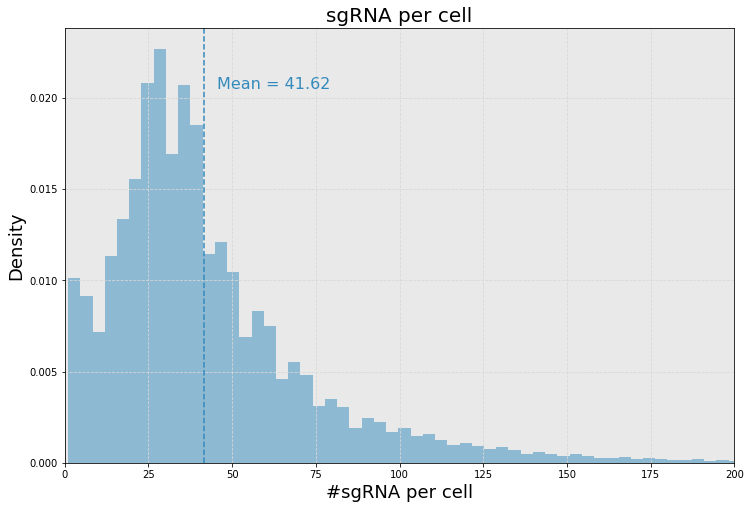

In [27]:
color_map = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

fig, ax = plt.subplots(figsize= (12,8))
ax.grid(ls='--', color='#D8D8D8')
ax.set_xlim(0,200)

ax.hist(CorrSgrnaPerCell_regex[np.argwhere(CorrSgrnaPerCell_regex.values > 0)], 
        color=color_map[0],
        bins=500, 
        density=True, 
        alpha=.5)

"""
ax.hist(CorrSgrnaPerCell_kallisto,
        color=color_map[1],
        bins=100, 
        density=True, 
        alpha=.5)
"""

ax.axvline(sgrna_mean_regex, 
           ls='--', 
           color=color_map[0])

"""
ax.axvline(sgrna_mean_kallisto, 
           ls='--', 
           color=color_map[1])
"""


xmin = 0
xmax = 200
ymin, ymax = ax.get_ylim()
x_offset = (xmax - xmin) * 0.02
y_offset = (ymax - ymin) * 0.02

"""
ax.text((sgrna_mean_kallisto + x_offset), 
        (0.03 + y_offset), 
        "Kallisto Mean = " + str(np.round(sgrna_mean_kallisto, decimals=2)), 
        color=color_map[1], 
        fontsize=16)
"""

ax.text((sgrna_mean_regex + x_offset), 
        (0.02 + y_offset), 
        "Mean = " + str(np.round(sgrna_mean_regex, decimals=2)), 
        color=color_map[0], 
        fontsize=16)



ax.set_facecolor('#E9E9E9')
ax.set_ylabel('Density', fontsize=18)
ax.set_xlabel('#sgRNA per cell', fontsize=18)
ax.set_title("sgRNA per cell", fontsize=20)
plt.show()

In [28]:
fig.savefig('/project/GCRB/Hon_lab/s426305/Analysis/Mosaic_seq_MB231-dCas9-KRAB+YWsg1/Files/regex_sgrna_per_cell_hist.png', dpi=200)